*Prasann Ranade <br>
Elliot Chuh*

**SUMMARY:**

Our solution addresses health accessibility for the county-average uninsured population whose income is less than 138% of the poverty line (or ~$36,000 for a family of 4).  Though the target population is proportionally small, it still amounts to over 100 million people in the U.S.  As an end-to-end solution that supports more than just the uninsured population, the goal is to utilize user-data and a clustering algorithm to recommend medical insurance policies and a compatible hospital.  The model uses the user’s county-level demographic data in combination with some extra datasets found on cms.gov for 2020 insurance policy data.  
  
  
Future development would utilize the ‘USA Hospital Bed Capacity’ dataset by fitting the hospital type with the client’s newly attained healthcare plan.
<br>

Since our data did not include a target feature like an insurance plan rating, we were forced to go with a clustering classification problem instead of a recommender system solution like funk svd.  After vectorizing the categorical features, and scaling the data, the relative measurement of inertia was very high.  Using PCA to reduce the feature number to 80 percent of explained variance through critical principal components, meaningful feature descriptions that we could use to segregate our clusters were lost. This likely prevents the model from being useful in staying within state/county borders or financial limits.  An alternative customization of the KMeans model could have involved manual distance weighting between states, counties, and prices in order to keep the cluster center as centralized to the state to ensure more localized recommendations.  

Further exploration would have required joining the dataset with the demographic data in order to leverage the user's demographic input.  This user data could be used in two ways:<br>
 1. The user's data is fed into the model as a row, similar to the training data and a prediction would reveal the nearest neighbors or insurance policies.
 2. The data is used for a separate neural network that learns associations between patient demographics, hospital registrations, and insurance sign-ups to be able to recommend the most common patterns among other local patients.



**PROCESS:**
- Imported all csv's
- Ran light EDA on no-show data
- Ran light EDA on Insurance data

- EDA on insurance plan data to formulate model to predict best plans based on demographic data, income, financial limitations, county location.
- Incorporated new insurance plan data sets from cms.gov to be able to cluster data points using insurance plan attributes and other datasets provided in this challenge.  Each row is an insurance policy with county services, premium, deductible, and policy 'metal' ratings.

- Scaling and PCA
- KMeans clustering - not fully optimized

Future Considerations:
- DBSCAN 
- Additional clustering needed for nearby hospitals based on hospital capacity data
- patient data 

Missed Opportunities:
- Distribution charts for each dataset as part of EDA
- 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [141]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [2]:
pd.set_option('display.max_columns', None)

# No-Show

No NaNs <br>
No duplicates

In [3]:
noshow_df = pd.read_csv('data/noshow_appt.csv')
noshow_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
noshow_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PatientId,110527.0,1.474963e+14,2.560949e+14,3.921784e+04,4.172614e+12,3.173184e+13,9.439172e+13,9.999816e+14
AppointmentID,110527.0,5.675305e+06,7.129575e+04,5.030230e+06,5.640286e+06,5.680573e+06,5.725524e+06,5.790484e+06
Age,110527.0,3.708887e+01,2.311020e+01,-1.000000e+00,1.800000e+01,3.700000e+01,5.500000e+01,1.150000e+02
Scholarship,110527.0,9.826558e-02,2.976748e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Hipertension,110527.0,1.972459e-01,3.979213e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Diabetes,110527.0,7.186479e-02,2.582651e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Alcoholism,110527.0,3.039981e-02,1.716856e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
Handcap,110527.0,2.224796e-02,1.615427e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
SMS_received,110527.0,3.210256e-01,4.668727e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


In [5]:
noshow_df['No-show'] = np.where(noshow_df['No-show']=='Yes', 1, 0)
noshow_df['No-show'] 

0         0
1         0
2         0
3         0
4         0
         ..
110522    0
110523    0
110524    0
110525    0
110526    0
Name: No-show, Length: 110527, dtype: int32

In [6]:
noshow_short_df = noshow_df.drop(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Handcap'], axis=1)
noshow_short_df

,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,No-show
0,62,JARDIM DA PENHA,0,1,0,0,0,0
1,56,JARDIM DA PENHA,0,0,0,0,0,0
2,62,MATA DA PRAIA,0,0,0,0,0,0
3,8,PONTAL DE CAMBURI,0,0,0,0,0,0
4,56,JARDIM DA PENHA,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...
110522,56,MARIA ORTIZ,0,0,0,0,1,0
110523,51,MARIA ORTIZ,0,0,0,0,1,0
110524,21,MARIA ORTIZ,0,0,0,0,1,0
110525,38,MARIA ORTIZ,0,0,0,0,1,0


In [7]:
noshow_conditions = noshow_short_df.drop(['Age'], axis=1)
noshow_conditions.describe().T

,count,mean,std,min,25%,50%,75%,max
Scholarship,110527.0,0.098266,0.297675,0.0,0.0,0.0,0.0,1.0
Hipertension,110527.0,0.197246,0.397921,0.0,0.0,0.0,0.0,1.0
Diabetes,110527.0,0.071865,0.258265,0.0,0.0,0.0,0.0,1.0
Alcoholism,110527.0,0.030400,0.171686,0.0,0.0,0.0,0.0,1.0
SMS_received,110527.0,0.321026,0.466873,0.0,0.0,0.0,1.0,1.0
No-show,110527.0,0.201933,0.401444,0.0,0.0,0.0,0.0,1.0


In [8]:
y = noshow_short_df['No-show']
X = noshow_short_df.drop('No-show', axis=1)
print(X.shape)
print(y.shape)

(110527, 7)
(110527,)


In [9]:
noshows = noshow_short_df[noshow_short_df['No-show']==1]
noshows.head()
print(noshows.shape[0])
noshows.sum()

22319


Age                                                         765936
Neighbourhood    GOIABEIRASGOIABEIRASNOVA PALESTINACONQUISTANOV...
Scholarship                                                   2578
Hipertension                                                  3772
Diabetes                                                      1430
Alcoholism                                                     677
SMS_received                                                  9784
No-show                                                      22319
dtype: object

In [10]:
shows = noshow_short_df[noshow_short_df['No-show']==0]
shows.head()
print(shows.shape[0])
shows.sum()


88208


Age                                                        3333386
Neighbourhood    JARDIM DA PENHAJARDIM DA PENHAMATA DA PRAIAPON...
Scholarship                                                   8283
Hipertension                                                 18029
Diabetes                                                      6513
Alcoholism                                                    2683
SMS_received                                                 25698
No-show                                                          0
dtype: object

In [11]:
noshow_conditions

,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,No-show
0,JARDIM DA PENHA,0,1,0,0,0,0
1,JARDIM DA PENHA,0,0,0,0,0,0
2,MATA DA PRAIA,0,0,0,0,0,0
3,PONTAL DE CAMBURI,0,0,0,0,0,0
4,JARDIM DA PENHA,0,1,1,0,0,0
...,...,...,...,...,...,...,...
110522,MARIA ORTIZ,0,0,0,0,1,0
110523,MARIA ORTIZ,0,0,0,0,1,0
110524,MARIA ORTIZ,0,0,0,0,1,0
110525,MARIA ORTIZ,0,0,0,0,1,0


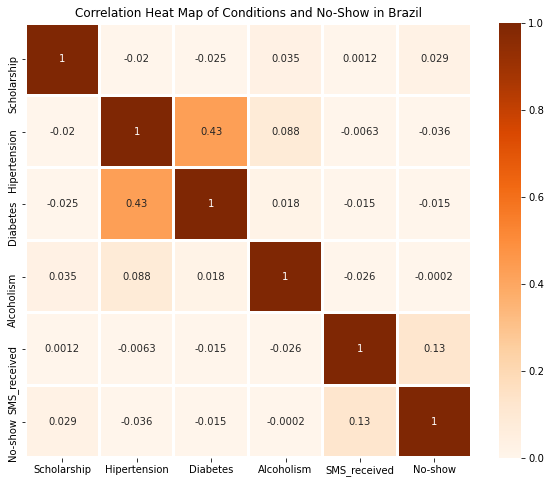

In [12]:
# Heatmap, MAGNITUDE of correlation 
plt.figure(figsize=(10,8))
sns.heatmap(noshow_conditions.corr(), cmap="Oranges", vmin=0, vmax=1, center=0.5, annot=True, linewidths=2)
plt.title('Correlation Heat Map of Conditions and No-Show in Brazil')
plt.show()

## <font color='red'>No-Show results and followup</font>

values are all between 0 and 1 except for handicap feature but doesn't seem to have much significant correlation to whether they showed or didn't show. 
- Diabetes patients are more likely to be a no-show.
- SMS received seems to very slightly negatively affect commitments to appointments.
  
What other tests can we use for this aside from statistical significance?

# Insurance
No NaNs <br>
No Duplicates

 
    Variable      Format      Description     
       year            4      Year of Estimate
       version         8      Release Version 
                                 Blank   : YEAR other than 2013, Only Version   
                                 Original: 2013 only, Original Version          
                                 Updated : 2013 only, Updated Version (May 2016)
       statefips       2      Unique FIPS code for each state                   
       countyfips      3      Unique FIPS code for each county within a state   
       geocat          2      Geography category             
                                40 - State geographic identifier 
                                50 - County geographic identifier
       agecat          1      Age category        
                                0 - Under 65 years
                                1 - 18 to 64 years
                                2 - 40 to 64 years
                                3 - 50 to 64 years
                                4 - Under 19 years
                                5 - 21 to 64 years
       racecat         1      Race category  
                                0 - All races
                                Only state estimates have racecat=1,2,3 values
                                1 - White alone, not Hispanic
                                2 - Black alone, not Hispanic
                                3 - Hispanic (any race)      
       sexcat          1      Sex category    
                                0 - Both sexes
                                1 - Male      
                                2 - Female    
       iprcat          1      Income category 
                                0 - All income levels          
                                1 - At or below 200% of poverty
                                2 - At or below 250% of poverty
                                3 - At or below 138% of poverty
                                4 - At or below 400% of poverty
                                5 - Between 138% - 400%  of poverty
      NIPR             8      Number in demographic group for <income category>
         nipr_moe      8           MOE  for NIPR
      NUI              8      Number uninsured  
         nui_moe       8           MOE  for NUI 
      NIC              8      Number insured    
         nic_moe       8           MOE  for NIC 
      PCTUI            5.1    Percent uninsured in demographic group for <income category>
         pctui_moe     5.1         MOE  for PCTUI                                 
      PCTIC            5.1    Percent insured in demographic group for <income category>  
         pctic_moe     5.1         MOE  for PCTIC                                 
      PCTELIG          5.1    Percent uninsured in demographic group for all income levels
         pctelig_moe   5.1         MOE  for PCTELIG                                
      PCTLIIC          5.1    Percent insured in demographic group for all income levels  
         pctliic_moe   5.1         MOE  for PCTLIIC                                
      state_name       70     State Name
      county_name      45     County Name
 
  PRIMARY KEY: year version statefips countyfips agecat racecat sexcat iprcat         
 
  Note 1:  A margin of error (MOE) is the difference between an estimate and its upper
  or lower confidence bounds. Confidence bounds can be created by adding the margin   
  of error to the estimate (for an upper bound) and subtracting the margin of error   
  from the estimate (for a lower bound). All published margins of error for the Small 
  Area Health Insurance Estimates program are based on a 90 percent confidence level. 
 
  Note 2:  The number in a demographic group is the number of people in the poverty   
  universe in that age, sex, and race/Hispanic origin group.                          
 
  Note 3:  Values for Kalawao, HI (15-005) should be considered N/A or missing.       
 
  Note 4:  MOEs of zero should be assumed to be <1 for counts and <0.1 for percentages.
 
  General Note:  Details may not sum to totals because of rounding.  

In [13]:
insurance_df = pd.read_csv('data/health_insurance.csv')
display(insurance_df.head(2))
insurance_df.describe().T

,year,statefips,countyfips,agecat,racecat,sexcat,iprcat,NIPR,NUI,NIC,PCTUI,PCTIC,PCTELIG,PCTLIIC,state_name,county_name
0,2018,1,1,0,0,0,0,46709,4693,42016,10.0,90.0,10.0,90.0,Alabama ...,Autauga County
1,2018,1,1,0,0,0,1,14248,2660,11588,18.7,81.3,5.7,24.8,Alabama ...,Autauga County


,count,mean,std,min,25%,50%,75%,max
year,301532.0,2018.000000,0.000000,2018.0,2018.0,2018.0,2018.0,2018.0
statefips,301532.0,30.284706,15.141872,1.0,18.0,29.0,45.0,56.0
countyfips,301532.0,103.601648,107.688186,1.0,35.0,79.0,133.0,840.0
agecat,301532.0,2.312498,1.721885,0.0,1.0,2.0,4.0,5.0
racecat,301532.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
sexcat,301532.0,0.937486,0.826795,0.0,0.0,1.0,2.0,2.0
iprcat,301532.0,2.500007,1.707834,0.0,1.0,2.5,4.0,5.0
NIPR,301532.0,15729.066258,72107.306434,1.0,1102.0,3134.0,9318.0,8577977.0
NUI,301532.0,2341.458290,11949.645875,0.0,154.0,444.0,1338.0,935213.0
NIC,301532.0,13387.607969,61736.334755,1.0,906.0,2620.0,7875.0,7703359.0


In [14]:
insurance_short = insurance_df.drop(['year', 'statefips', 'countyfips', 'sexcat', 'NIPR', 'NUI', 'NIC', 'state_name', 'county_name'], axis=1)
insurance_short

,agecat,racecat,iprcat,PCTUI,PCTIC,PCTELIG,PCTLIIC
0,0,0,0,10.0,90.0,10.0,90.0
1,0,0,1,18.7,81.3,5.7,24.8
2,0,0,2,17.3,82.7,6.8,32.4
3,0,0,3,20.0,80.0,4.0,16.2
4,0,0,4,13.6,86.4,8.7,55.3
...,...,...,...,...,...,...,...
301527,5,0,1,23.4,76.6,5.9,19.2
301528,5,0,2,22.3,77.7,7.4,25.8
301529,5,0,3,25.0,75.0,4.2,12.5
301530,5,0,4,18.2,81.8,9.9,44.7


In [15]:
insurance_short.groupby('iprcat').mean()

,agecat,racecat,PCTUI,PCTIC,PCTELIG,PCTLIIC
iprcat,,,,,,
0,2.312500,0.0,11.645652,88.354348,11.645652,88.354395
1,2.312493,0.0,19.487452,80.512548,6.127244,25.627381
2,2.312500,0.0,18.518278,81.481722,7.446484,32.898265
3,2.312493,0.0,20.547624,79.452376,4.149938,16.394351
4,2.312500,0.0,15.421995,84.578005,9.856964,53.615146
5,2.312500,0.0,13.203357,86.796643,5.707267,37.221317


       iprcat          1      Income category 
                                0 - All income levels          
                                1 - At or below 200% of poverty
                                2 - At or below 250% of poverty
                                3 - At or below 138% of poverty
                                4 - At or below 400% of poverty
                                5 - Between 138% - 400%  of poverty

In [16]:
ins_chart = insurance_short[['iprcat', 'PCTUI', 'PCTIC']]
ins_chart_iprcat_grouped = ins_chart.groupby('iprcat').mean()
ins_chart_iprcat_grouped

,PCTUI,PCTIC
iprcat,,
0,11.645652,88.354348
1,19.487452,80.512548
2,18.518278,81.481722
3,20.547624,79.452376
4,15.421995,84.578005
5,13.203357,86.796643


In [17]:
iprcats = {}

In [19]:
# sns.set()
# ins_chart.set_index('iprcat').T.plot(kind='bar', stacked=True)

Across all income levels: 11.6% uninsured.  88% insured

 - (4) At or below 400% of poverty: 15.4% uninsured. 84.5% insured. 
 - (5) Between 138% and 400% of poverty: 13.2% uninsured. 86% uninsured.  Accounts for 5.7% of all uninsured and 37.2% of all insured.
 - (3) At or Below 138% of poverty: 20.5% uninsured. 79.4% uninsured.  Accounts for 4.1% of all uninsured and 16% of all insured.
  
  
This means that 1.8% of uninsured comes from incomes more than 400% of poverty.

# Hospital Capacity

In [20]:
# beds_df = pd.read_csv('data/hospital_capacity.csv')
# beds_df.head()

# Nurses / Midwives

In [21]:
# nurses_df = pd.read_csv('data/nurses_midwives.csv')
# nurses_df

# Demographics

# Jobs

In [22]:
# job_df = pd.read_csv('data/emed_careers_eu.csv')
# job_df

In [23]:
# job_df.loc[1, 'job_description']

# HCAHPS

In [24]:
# hcahps_df = pd.read_csv('data/hcahps_state_clean_answer_pct.csv')
# hcahps_df.describe().T

In [25]:
# qhp_ind = pd.read_csv('newdata/QHP landscape individual/QHP_Landscape_Individual_Market_Medical.csv')
# pd.set_option('display.max_columns', None)
# qhp_ind.head()

# Plan attr
from https://www.cms.gov/CCIIO/Resources/Data-Resources/marketplace-puf <br>

also considered https://data.healthcare.gov/dataset/QHP-Landscape-Individual-Market-Medical/b8in-sz6k

Variable Name: IssuerId
Variable Definition: Five-digit numeric code that identifies the issuer organization in the
Health Insurance Oversight System (HIOS)

Variable Name: ServiceAreaId
Variable Definition: Identifier for a service area

Variable Name: IssuerMarketplaceMarketingName
Variable Definition: Marketplace Marketing name of insurance company



find fips -> search plan attr

concat plan_attr_df with 

In [26]:
plan_attr_df = pd.read_csv('newdata/2021 exchange PUF/Plan_Attributes_PUF.csv')
plan_attr_df.head()

C:\Users\ikhwan\.conda\envs\bigdata_ml\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (79,80,81,85,86,87,88,89,90,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,BusinessYear,StateCode,IssuerId,IssuerMarketPlaceMarketingName,SourceName,ImportDate,MarketCoverage,DentalOnlyPlan,StandardComponentId,PlanMarketingName,HIOSProductId,NetworkId,ServiceAreaId,FormularyId,IsNewPlan,PlanType,MetalLevel,UniquePlanDesign,QHPNonQHPTypeId,IsNoticeRequiredForPregnancy,IsReferralRequiredForSpecialist,SpecialistRequiringReferral,PlanLevelExclusions,IndianPlanVariationEstimatedAdvancedPaymentAmountPerEnrollee,CompositeRatingOffered,ChildOnlyOffering,ChildOnlyPlanId,WellnessProgramOffered,DiseaseManagementProgramsOffered,EHBPercentTotalPremium,EHBPediatricDentalApportionmentQuantity,IsGuaranteedRate,PlanEffectiveDate,PlanExpirationDate,OutOfCountryCoverage,OutOfCountryCoverageDescription,OutOfServiceAreaCoverage,OutOfServiceAreaCoverageDescription,NationalNetwork,URLForEnrollmentPayment,FormularyURL,PlanId,PlanVariantMarketingName,CSRVariationType,IssuerActuarialValue,AVCalculatorOutputNumber,MedicalDrugDeductiblesIntegrated,MedicalDrugMaximumOutofPocketIntegrated,MultipleInNetworkTiers,FirstTierUtilization,SecondTierUtilization,SBCHavingaBabyDeductible,SBCHavingaBabyCopayment,SBCHavingaBabyCoinsurance,SBCHavingaBabyLimit,SBCHavingDiabetesDeductible,SBCHavingDiabetesCopayment,SBCHavingDiabetesCoinsurance,SBCHavingDiabetesLimit,SBCHavingSimplefractureDeductible,SBCHavingSimplefractureCopayment,SBCHavingSimplefractureCoinsurance,SBCHavingSimplefractureLimit,SpecialtyDrugMaximumCoinsurance,InpatientCopaymentMaximumDays,BeginPrimaryCareCostSharingAfterNumberOfVisits,BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays,MEHBInnTier1IndividualMOOP,MEHBInnTier1FamilyPerPersonMOOP,MEHBInnTier1FamilyPerGroupMOOP,MEHBInnTier2IndividualMOOP,MEHBInnTier2FamilyPerPersonMOOP,MEHBInnTier2FamilyPerGroupMOOP,MEHBOutOfNetIndividualMOOP,MEHBOutOfNetFamilyPerPersonMOOP,MEHBOutOfNetFamilyPerGroupMOOP,MEHBCombInnOonIndividualMOOP,MEHBCombInnOonFamilyPerPersonMOOP,MEHBCombInnOonFamilyPerGroupMOOP,DEHBInnTier1IndividualMOOP,DEHBInnTier1FamilyPerPersonMOOP,DEHBInnTier1FamilyPerGroupMOOP,DEHBInnTier2IndividualMOOP,DEHBInnTier2FamilyPerPersonMOOP,DEHBInnTier2FamilyPerGroupMOOP,DEHBOutOfNetIndividualMOOP,DEHBOutOfNetFamilyPerPersonMOOP,DEHBOutOfNetFamilyPerGroupMOOP,DEHBCombInnOonIndividualMOOP,DEHBCombInnOonFamilyPerPersonMOOP,DEHBCombInnOonFamilyPerGroupMOOP,TEHBInnTier1IndividualMOOP,TEHBInnTier1FamilyPerPersonMOOP,TEHBInnTier1FamilyPerGroupMOOP,TEHBInnTier2IndividualMOOP,TEHBInnTier2FamilyPerPersonMOOP,TEHBInnTier2FamilyPerGroupMOOP,TEHBOutOfNetIndividualMOOP,TEHBOutOfNetFamilyPerPersonMOOP,TEHBOutOfNetFamilyPerGroupMOOP,TEHBCombInnOonIndividualMOOP,TEHBCombInnOonFamilyPerPersonMOOP,TEHBCombInnOonFamilyPerGroupMOOP,MEHBDedInnTier1Individual,MEHBDedInnTier1FamilyPerPerson,MEHBDedInnTier1FamilyPerGroup,MEHBDedInnTier1Coinsurance,MEHBDedInnTier2Individual,MEHBDedInnTier2FamilyPerPerson,MEHBDedInnTier2FamilyPerGroup,MEHBDedInnTier2Coinsurance,MEHBDedOutOfNetIndividual,MEHBDedOutOfNetFamilyPerPerson,MEHBDedOutOfNetFamilyPerGroup,MEHBDedCombInnOonIndividual,MEHBDedCombInnOonFamilyPerPerson,MEHBDedCombInnOonFamilyPerGroup,DEHBDedInnTier1Individual,DEHBDedInnTier1FamilyPerPerson,DEHBDedInnTier1FamilyPerGroup,DEHBDedInnTier1Coinsurance,DEHBDedInnTier2Individual,DEHBDedInnTier2FamilyPerPerson,DEHBDedInnTier2FamilyPerGroup,DEHBDedInnTier2Coinsurance,DEHBDedOutOfNetIndividual,DEHBDedOutOfNetFamilyPerPerson,DEHBDedOutOfNetFamilyPerGroup,DEHBDedCombInnOonIndividual,DEHBDedCombInnOonFamilyPerPerson,DEHBDedCombInnOonFamilyPerGroup,TEHBDedInnTier1Individual,TEHBDedInnTier1FamilyPerPerson,TEHBDedInnTier1FamilyPerGroup,TEHBDedInnTier1Coinsurance,TEHBDedInnTier2Individual,TEHBDedInnTier2FamilyPerPerson,TEHBDedInnTier2FamilyPerGroup,TEHBDedInnTier2Coinsurance,TEHBDedOutOfNetIndividual,TEHBDedOutOfNetFamilyPerPerson,TEHBDedOutOfNetFamilyPerGroup,TEHBDedCombInnOonIndividual,TEHBDedCombInnOonFamilyPerPerson,TEHBDedCombInnOonFamilyPerGroup,IsHSAEligible,HSAOrHRAEmployerContribution,HSAOrHRAEmployerContributionAmount,URLForSummaryofBenefitsCoverage,P

In [27]:
print(plan_attr_df.shape)

(20236, 150)


In [28]:
columns_list = ['StateCode', 'IssuerId', 'StandardComponentId', 'IssuerMarketPlaceMarketingName', 'DentalOnlyPlan', 'NetworkId', 'MetalLevel', 'TEHBDedInnTier1Individual', 'TEHBDedOutOfNetIndividual', 'TEHBDedCombInnOonIndividual', 'OutOfCountryCoverage', 'OutOfServiceAreaCoverage', 'MarketCoverage']

In [29]:
plan_attr_short = plan_attr_df[columns_list]
plan_attr_short

,StateCode,IssuerId,StandardComponentId,IssuerMarketPlaceMarketingName,DentalOnlyPlan,NetworkId,MetalLevel,TEHBDedInnTier1Individual,TEHBDedOutOfNetIndividual,TEHBDedCombInnOonIndividual,OutOfCountryCoverage,OutOfServiceAreaCoverage,MarketCoverage
0,AK,21989,21989AK0070001,Delta Dental of Alaska,Yes,AKN001,Low,NaN,NaN,NaN,Yes,Yes,Individual
1,AK,21989,21989AK0080001,Delta Dental of Alaska,Yes,AKN001,High,NaN,NaN,NaN,Yes,Yes,SHOP (Small Group)
2,AK,21989,21989AK0080002,Delta Dental of Alaska,Yes,AKN001,High,NaN,NaN,NaN,Yes,Yes,SHOP (Small Group)
3,AK,21989,21989AK0080003,Delta Dental of Alaska,Yes,AKN001,High,NaN,NaN,NaN,Yes,Yes,SHOP (Small Group)
4,AK,21989,21989AK0030001,Delta Dental of Alaska,Yes,AKN001,Low,NaN,NaN,NaN,Yes,Yes,Individual
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20231,OH,28162,28162OH0090059,AultCare Insurance Company,No,OHN001,Silver,"$4,250","$12,750",Not Applicable,Yes,Yes,SHOP (Small Group)
20232,OH,28162,28162OH0090060,AultCare Insurance Company,No,OHN001,Silver,NaN,NaN,NaN,Yes,Yes,SHOP (Small Group)
20233,OH,28162,28162OH0090060,AultCare Insurance Company,No,OHN001,Silver,NaN,NaN,NaN,Yes,Yes,SHOP (Small Group)
20234,OH,28162,28162OH0090062,AultCare Insurance Company,No,OHN001,Expanded Bronze,"$6,850","$20,550",Not Applicable,Yes,Yes,SHOP (Small Group)


In [30]:
plan_attr_short.isna().sum()

StateCode                            0
IssuerId                             0
StandardComponentId                  0
IssuerMarketPlaceMarketingName       0
DentalOnlyPlan                       0
NetworkId                            0
MetalLevel                           0
TEHBDedInnTier1Individual         5187
TEHBDedOutOfNetIndividual         5187
TEHBDedCombInnOonIndividual       5187
OutOfCountryCoverage                 0
OutOfServiceAreaCoverage             0
MarketCoverage                       0
dtype: int64

In [31]:
plan_attr_short = plan_attr_short.dropna()

In [32]:
plan_attr_short.isna().sum()

StateCode                         0
IssuerId                          0
StandardComponentId               0
IssuerMarketPlaceMarketingName    0
DentalOnlyPlan                    0
NetworkId                         0
MetalLevel                        0
TEHBDedInnTier1Individual         0
TEHBDedOutOfNetIndividual         0
TEHBDedCombInnOonIndividual       0
OutOfCountryCoverage              0
OutOfServiceAreaCoverage          0
MarketCoverage                    0
dtype: int64

# service area

In [33]:
service_area = pd.read_csv('newdata/2021 exchange PUF/Service_Area_PUF.csv')
service_area.head()

,BusinessYear,StateCode,IssuerId,SourceName,ImportDate,ServiceAreaId,ServiceAreaName,CoverEntireState,County,PartialCounty,ZipCodes,PartialCountyJustification,MarketCoverage,DentalOnlyPlan
0,2021,AK,21989,HIOS,2020-07-31 03:20:18,AKS001,Alaska Premier,Yes,NaN,NaN,NaN,NaN,Individual,Yes
1,2021,AK,21989,HIOS,2020-07-31 03:20:18,AKS001,Alaska Premier,Yes,NaN,NaN,NaN,NaN,SHOP (Small Group),Yes
2,2021,AK,21989,HIOS,2020-07-31 03:20:18,AKS002,Alaska PPO,No,2020.0,No,NaN,NaN,Individual,Yes
3,2021,AK,21989,HIOS,2020-07-31 03:20:18,AKS002,Alaska PPO,No,2020.0,No,NaN,NaN,SHOP (Small Group),Yes
4,2021,AK,21989,HIOS,2020-07-31 03:20:18,AKS002,Alaska PPO,No,2090.0,No,NaN,NaN,SHOP (Small Group),Yes


In [34]:
service_columns_list = ['IssuerId', 'County']

In [35]:
service_area_short = service_area[service_columns_list]
service_area_short

,IssuerId,County
0,21989,NaN
1,21989,NaN
2,21989,2020.0
3,21989,2020.0
4,21989,2090.0
...,...,...
11316,97762,NaN
11317,31274,NaN
11318,50328,NaN
11319,76526,NaN


In [36]:
service_area_short.isna().sum()

IssuerId      0
County      282
dtype: int64

## join tables

In [37]:
print(plan_attr_short.shape)
print(service_area_short.shape)

(15049, 13)
(11321, 2)


In [38]:
full_plan_df = pd.merge(plan_attr_short, service_area_short, how='left', on='IssuerId', )

In [39]:
full_plan_df.shape

(1013086, 14)

In [40]:
full_plan_df.head()

,StateCode,IssuerId,StandardComponentId,IssuerMarketPlaceMarketingName,DentalOnlyPlan,NetworkId,MetalLevel,TEHBDedInnTier1Individual,TEHBDedOutOfNetIndividual,TEHBDedCombInnOonIndividual,OutOfCountryCoverage,OutOfServiceAreaCoverage,MarketCoverage,County
0,AK,38344,38344AK1060001,Premera Blue Cross Blue Shield of Alaska,No,AKN001,Gold,"$1,500","$3,000",Not Applicable,Yes,Yes,Individual,NaN
1,AK,38344,38344AK1060001,Premera Blue Cross Blue Shield of Alaska,No,AKN001,Gold,"$1,500","$3,000",Not Applicable,Yes,Yes,Individual,NaN
2,AK,38344,38344AK1060001,Premera Blue Cross Blue Shield of Alaska,No,AKN001,Gold,"$1,500","$3,000",Not Applicable,Yes,Yes,Individual,NaN
3,AK,38344,38344AK1060001,Premera Blue Cross Blue Shield of Alaska,No,AKN001,Gold,$0,$0,$0,Yes,Yes,Individual,NaN
4,AK,38344,38344AK1060002,Premera Blue Cross Blue Shield of Alaska,No,AKN001,Silver,"$4,500","$9,000",Not Applicable,Yes,Yes,Individual,NaN


In [41]:
full_plan_df = full_plan_df.drop_duplicates()
full_plan_df.duplicated().sum()

0

In [42]:
for i in full_plan_df.columns:
    print(i)
    print(full_plan_df[i].isna().sum())

StateCode
0
IssuerId
0
StandardComponentId
0
IssuerMarketPlaceMarketingName
0
DentalOnlyPlan
0
NetworkId
0
MetalLevel
0
TEHBDedInnTier1Individual
0
TEHBDedOutOfNetIndividual
0
TEHBDedCombInnOonIndividual
0
OutOfCountryCoverage
0
OutOfServiceAreaCoverage
0
MarketCoverage
0
County
3429


In [43]:
full_plan_df = full_plan_df[full_plan_df['County'].notna()]

In [44]:
full_plan_df.shape

(496239, 14)

In [45]:
full_plan_df.columns

Index(['StateCode', 'IssuerId', 'StandardComponentId',
       'IssuerMarketPlaceMarketingName', 'DentalOnlyPlan', 'NetworkId',
       'MetalLevel', 'TEHBDedInnTier1Individual', 'TEHBDedOutOfNetIndividual',
       'TEHBDedCombInnOonIndividual', 'OutOfCountryCoverage',
       'OutOfServiceAreaCoverage', 'MarketCoverage', 'County'],
      dtype='object')

In [46]:
full_plan_df.isna().sum()

StateCode                         0
IssuerId                          0
StandardComponentId               0
IssuerMarketPlaceMarketingName    0
DentalOnlyPlan                    0
NetworkId                         0
MetalLevel                        0
TEHBDedInnTier1Individual         0
TEHBDedOutOfNetIndividual         0
TEHBDedCombInnOonIndividual       0
OutOfCountryCoverage              0
OutOfServiceAreaCoverage          0
MarketCoverage                    0
County                            0
dtype: int64

In [47]:
# columns_list = full_plan_df_copy.loc[:,full_plan_df_copy.columns.str.contains('Coverage')].columns
# columns_list

In [48]:
# for i in columns_list:
#     print(i)
#     print(full_plan_df_copy[i].isna().sum())

# Rate
no nans <br>
no duplicates

In [49]:
rate_df = pd.read_csv('newdata/2021 exchange PUF/Rate_PUF.csv')
rate_df.head()

,BusinessYear,StateCode,IssuerId,SourceName,ImportDate,RateEffectiveDate,RateExpirationDate,PlanId,RatingAreaId,Tobacco,Age,IndividualRate,IndividualTobaccoRate,Couple,PrimarySubscriberAndOneDependent,PrimarySubscriberAndTwoDependents,PrimarySubscriberAndThreeOrMoreDependents,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents
0,2021,AK,21989,HIOS,2020-07-31 03:20:18,2021-01-01,2021-03-31,21989AK0080001,Rating Area 1,NaN,Family Option,51.23,NaN,106.56,122.95,122.95,122.95,183.41,183.41,183.41
1,2021,AK,21989,HIOS,2020-07-31 03:20:18,2021-01-01,2021-03-31,21989AK0080001,Rating Area 2,NaN,Family Option,51.23,NaN,106.56,122.95,122.95,122.95,183.41,183.41,183.41
2,2021,AK,21989,HIOS,2020-07-31 03:20:18,2021-01-01,2021-03-31,21989AK0080001,Rating Area 3,NaN,Family Option,51.23,NaN,106.56,122.95,122.95,122.95,183.41,183.41,183.41
3,2021,AK,21989,HIOS,2020-07-31 03:20:18,2021-01-01,2021-03-31,21989AK0080002,Rating Area 1,NaN,Family Option,59.24,NaN,123.22,142.18,142.18,142.18,212.08,212.08,212.08
4,2021,AK,21989,HIOS,2020-07-31 03:20:18,2021-01-01,2021-03-31,21989AK0080002,Rating Area 2,NaN,Family Option,59.24,NaN,123.22,142.18,142.18,142.18,212.08,212.08,212.08


In [50]:
rate_df['Age'] = rate_df[rate_df['Age'] != 'Family Option']

In [51]:
rate_df.duplicated().sum()

861345

In [52]:
rate_df = rate_df.drop_duplicates()

In [53]:
rate_df.isna().sum()

BusinessYear                                       0
StateCode                                          0
IssuerId                                           0
SourceName                                         0
ImportDate                                         0
RateEffectiveDate                                  0
RateExpirationDate                                 0
PlanId                                             0
RatingAreaId                                       0
Tobacco                                         1182
Age                                             1182
IndividualRate                                     0
IndividualTobaccoRate                         475913
Couple                                       1276728
PrimarySubscriberAndOneDependent             1276728
PrimarySubscriberAndTwoDependents            1276728
PrimarySubscriberAndThreeOrMoreDependents    1276728
CoupleAndOneDependent                        1276728
CoupleAndTwoDependents                       1

In [54]:
rate_df2 = rate_df[['PlanId', 'IndividualRate']]

In [55]:
rate_df2 = rate_df2.dropna()
rate_df2.head(2)

,PlanId,IndividualRate
0,21989AK0080001,51.23
1,21989AK0080001,51.23


In [56]:
rate_df2.shape

(1277910, 2)

In [57]:
rate_df2 = rate_df2.groupby('PlanId').mean()

In [58]:
rate_df2.shape
rate_df2

,IndividualRate
PlanId,
10046HI0020003,44.366000
10046HI0020004,39.530000
10046HI0020005,35.716000
10046HI0020006,29.344000
10091OR0680001,338.785714
...,...
99969OH0080239,484.021667
99969OH0080240,451.692696
99969OH0080241,434.390637


In [59]:
print(full_plan_df.shape)
print(rate_df2.shape)

(496239, 14)
(4997, 1)


In [60]:
full_plan_df = full_plan_df.rename(columns={'StandardComponentId': 'PlanId'})
full_plan_df.columns

Index(['StateCode', 'IssuerId', 'PlanId', 'IssuerMarketPlaceMarketingName',
       'DentalOnlyPlan', 'NetworkId', 'MetalLevel',
       'TEHBDedInnTier1Individual', 'TEHBDedOutOfNetIndividual',
       'TEHBDedCombInnOonIndividual', 'OutOfCountryCoverage',
       'OutOfServiceAreaCoverage', 'MarketCoverage', 'County'],
      dtype='object')

In [61]:
print(full_plan_df.shape)
print(rate_df2.shape)

(496239, 14)
(4997, 1)


In [62]:
display(full_plan_df.head(2))
display(rate_df.head(2))

,StateCode,IssuerId,PlanId,IssuerMarketPlaceMarketingName,DentalOnlyPlan,NetworkId,MetalLevel,TEHBDedInnTier1Individual,TEHBDedOutOfNetIndividual,TEHBDedCombInnOonIndividual,OutOfCountryCoverage,OutOfServiceAreaCoverage,MarketCoverage,County
24,AK,77963,77963AK0010001,Moda Health,No,AKN001,Gold,"$1,500","$9,000",Not Applicable,No,Yes,Individual,2020.0
25,AK,77963,77963AK0010001,Moda Health,No,AKN001,Gold,"$1,500","$9,000",Not Applicable,No,Yes,Individual,2090.0


,BusinessYear,StateCode,IssuerId,SourceName,ImportDate,RateEffectiveDate,RateExpirationDate,PlanId,RatingAreaId,Tobacco,Age,IndividualRate,IndividualTobaccoRate,Couple,PrimarySubscriberAndOneDependent,PrimarySubscriberAndTwoDependents,PrimarySubscriberAndThreeOrMoreDependents,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents
0,2021,AK,21989,HIOS,2020-07-31 03:20:18,2021-01-01,2021-03-31,21989AK0080001,Rating Area 1,NaN,NaN,51.23,NaN,106.56,122.95,122.95,122.95,183.41,183.41,183.41
1,2021,AK,21989,HIOS,2020-07-31 03:20:18,2021-01-01,2021-03-31,21989AK0080001,Rating Area 2,NaN,NaN,51.23,NaN,106.56,122.95,122.95,122.95,183.41,183.41,183.41


In [63]:
full_plan_df.dtypes

StateCode                          object
IssuerId                            int64
PlanId                             object
IssuerMarketPlaceMarketingName     object
DentalOnlyPlan                     object
NetworkId                          object
MetalLevel                         object
TEHBDedInnTier1Individual          object
TEHBDedOutOfNetIndividual          object
TEHBDedCombInnOonIndividual        object
OutOfCountryCoverage               object
OutOfServiceAreaCoverage           object
MarketCoverage                     object
County                            float64
dtype: object

In [64]:
plan_df = full_plan_df.copy()

In [65]:
plan_df['TEHBDedCombInnOonIndividual'].unique()

array(['Not Applicable', '$0 ', '$2,925 ', '$6,100 ', '$2,150 ',
       '$7,450 ', '$725 ', '$5,975 ', '$5,200 ', '$3,450 ', '$8,000 ',
       '$7,700 ', '$2,000 ', '$6,000 ', '$450 ', '$1,300 ', '$5,700 ',
       '$5,800 ', '$5,500 ', '$1,200 ', '$400 ', '$350 ', '$4,950 ',
       '$5,100 ', '$900 ', '$5,400 ', '$22,300 ', '$27,000 ', '$20,150 ',
       '$25,000 ', '$21,000 ', '$28,550 ', '$26,950 ', '$20,000 ',
       '$18,000 ', '$19,500 ', '$20,700 ', '$9,000 ', '$3,000 ',
       '$24,000 ', '$8,550 ', '$11,000 ', '$8,950 ', '$11,200 ',
       '$8,600 ', '$11,600 ', '$14,000 ', '$10,700 ', '$26,000 ',
       '$13,600 ', '$18,200 ', '$10,300 ', '$12,200 ', '$10,800 ',
       '$9,250 ', '$11,400 ', '$8,900 ', '$4,600 ', '$4,300 ', '$550 ',
       '$125 ', '$8,200 ', '$5,650 ', '$3,150 ', '$1,325 ', '$575 ',
       '$325 ', '$6,500 ', '$6,900 ', '$2,625 ', '$500 ', '$7,350 ',
       '$5,350 ', '$1,950 ', '$675 ', '$2,700 ', '$850 ', '$200 ',
       '$1,000 ', '$7,800 ', '$5,000 ', '$1

In [66]:
plan_df[['TEHBDedInnTier1Individual', 'TEHBDedOutOfNetIndividual', 'TEHBDedCombInnOonIndividual']] = plan_df[['TEHBDedInnTier1Individual', 'TEHBDedOutOfNetIndividual', 'TEHBDedCombInnOonIndividual']].apply(lambda x: x.str.replace('$','').str.replace(',', '').str.replace(' ',''))

<ipython-input-66-a2be31bafcc5>:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  plan_df[['TEHBDedInnTier1Individual', 'TEHBDedOutOfNetIndividual', 'TEHBDedCombInnOonIndividual']] = plan_df[['TEHBDedInnTier1Individual', 'TEHBDedOutOfNetIndividual', 'TEHBDedCombInnOonIndividual']].apply(lambda x: x.str.replace('$','').str.replace(',', '').str.replace(' ',''))


In [67]:
plan_df = plan_df[plan_df.TEHBDedOutOfNetIndividual != 'NotApplicable']
plan_df = plan_df[plan_df.TEHBDedCombInnOonIndividual != 'NotApplicable']

In [68]:
plan_df['TEHBDedInnTier1Individual'] = plan_df['TEHBDedInnTier1Individual'].astype(int)
plan_df['TEHBDedOutOfNetIndividual'] = plan_df['TEHBDedOutOfNetIndividual'].astype(int)
plan_df['TEHBDedCombInnOonIndividual'] = plan_df['TEHBDedCombInnOonIndividual'].astype(int)

In [69]:
plan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88482 entries, 36 to 1012847
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   StateCode                       88482 non-null  object 
 1   IssuerId                        88482 non-null  int64  
 2   PlanId                          88482 non-null  object 
 3   IssuerMarketPlaceMarketingName  88482 non-null  object 
 4   DentalOnlyPlan                  88482 non-null  object 
 5   NetworkId                       88482 non-null  object 
 6   MetalLevel                      88482 non-null  object 
 7   TEHBDedInnTier1Individual       88482 non-null  int32  
 8   TEHBDedOutOfNetIndividual       88482 non-null  int32  
 9   TEHBDedCombInnOonIndividual     88482 non-null  int32  
 10  OutOfCountryCoverage            88482 non-null  object 
 11  OutOfServiceAreaCoverage        88482 non-null  object 
 12  MarketCoverage               

In [70]:
plan_df.head(2)

,StateCode,IssuerId,PlanId,IssuerMarketPlaceMarketingName,DentalOnlyPlan,NetworkId,MetalLevel,TEHBDedInnTier1Individual,TEHBDedOutOfNetIndividual,TEHBDedCombInnOonIndividual,OutOfCountryCoverage,OutOfServiceAreaCoverage,MarketCoverage,County
36,AK,77963,77963AK0010001,Moda Health,No,AKN001,Gold,0,0,0,No,Yes,Individual,2020.0
37,AK,77963,77963AK0010001,Moda Health,No,AKN001,Gold,0,0,0,No,Yes,Individual,2090.0


In [71]:
# plan_df.to_csv('attr_serv.csv')

In [72]:
# rate_df_short.to_csv('rate_df_short.csv')

In [73]:
# df_outer = pd.merge(plan_df, rate_df_shorter, on='PlanId', how='outer')

In [74]:
# 367825701
full_plan = pd.merge(plan_df, rate_df2, on='PlanId')

In [75]:
full_plan.shape

(88482, 15)

In [76]:
full_plan

,StateCode,IssuerId,PlanId,IssuerMarketPlaceMarketingName,DentalOnlyPlan,NetworkId,MetalLevel,TEHBDedInnTier1Individual,TEHBDedOutOfNetIndividual,TEHBDedCombInnOonIndividual,OutOfCountryCoverage,OutOfServiceAreaCoverage,MarketCoverage,County,IndividualRate
0,AK,77963,77963AK0010001,Moda Health,No,AKN001,Gold,0,0,0,No,Yes,Individual,2020.0,766.229167
1,AK,77963,77963AK0010001,Moda Health,No,AKN001,Gold,0,0,0,No,Yes,Individual,2090.0,766.229167
2,AK,77963,77963AK0010001,Moda Health,No,AKN001,Gold,0,0,0,No,Yes,Individual,2122.0,766.229167
3,AK,77963,77963AK0010001,Moda Health,No,AKN001,Gold,0,0,0,No,Yes,Individual,2130.0,766.229167
4,AK,77963,77963AK0010001,Moda Health,No,AKN001,Gold,0,0,0,No,Yes,Individual,2170.0,766.229167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88477,OH,28162,28162OH0060104,AultCare Insurance Company,No,OHN002,Expanded Bronze,0,0,0,Yes,Yes,Individual,39151.0,421.156458
88478,OH,28162,28162OH0060104,AultCare Insurance Company,No,OHN002,Expanded Bronze,0,0,0,Yes,Yes,Individual,39157.0,421.156458
88479,OH,28162,28162OH0060104,AultCare Insurance Company,No,OHN002,Expanded Bronze,0,0,0,Yes,Yes,Individual,39075.0,421.156458
88480,OH,28162,28162OH0060104,AultCare Insurance Company,No,OHN002,Expanded Bronze,0,0,0,Yes,Yes,Individual,39153.0,421.156458


In [77]:
full_plan.to_csv('full_plan.csv')

final column selection and one hot encoding

In [78]:
full_plan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88482 entries, 0 to 88481
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   StateCode                       88482 non-null  object 
 1   IssuerId                        88482 non-null  int64  
 2   PlanId                          88482 non-null  object 
 3   IssuerMarketPlaceMarketingName  88482 non-null  object 
 4   DentalOnlyPlan                  88482 non-null  object 
 5   NetworkId                       88482 non-null  object 
 6   MetalLevel                      88482 non-null  object 
 7   TEHBDedInnTier1Individual       88482 non-null  int32  
 8   TEHBDedOutOfNetIndividual       88482 non-null  int32  
 9   TEHBDedCombInnOonIndividual     88482 non-null  int32  
 10  OutOfCountryCoverage            88482 non-null  object 
 11  OutOfServiceAreaCoverage        88482 non-null  object 
 12  MarketCoverage                  

In [79]:
full_plan.drop(['IssuerId', 'NetworkId', 'DentalOnlyPlan'], axis=1, inplace=True)

In [80]:
full_plan.to_csv('full_plan.csv')

In [81]:
full_plan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88482 entries, 0 to 88481
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   StateCode                       88482 non-null  object 
 1   PlanId                          88482 non-null  object 
 2   IssuerMarketPlaceMarketingName  88482 non-null  object 
 3   MetalLevel                      88482 non-null  object 
 4   TEHBDedInnTier1Individual       88482 non-null  int32  
 5   TEHBDedOutOfNetIndividual       88482 non-null  int32  
 6   TEHBDedCombInnOonIndividual     88482 non-null  int32  
 7   OutOfCountryCoverage            88482 non-null  object 
 8   OutOfServiceAreaCoverage        88482 non-null  object 
 9   MarketCoverage                  88482 non-null  object 
 10  County                          88482 non-null  float64
 11  IndividualRate                  88482 non-null  float64
dtypes: float64(2), int32(3), object(

In [82]:
full_plan['IndividualRate'] = full_plan['IndividualRate'].round()

In [83]:
full_plan['County'] = full_plan['County'].round()

In [84]:
full_plan['IndividualRate'] = full_plan['IndividualRate'].astype('int64')
full_plan['TEHBDedInnTier1Individual'] = full_plan['TEHBDedInnTier1Individual'].astype('int64')
full_plan['TEHBDedOutOfNetIndividual'] = full_plan['TEHBDedOutOfNetIndividual'].astype('int64')
full_plan['TEHBDedCombInnOonIndividual'] = full_plan['TEHBDedCombInnOonIndividual'].astype('int64')

In [86]:
full_plan['County'] = full_plan['County'].astype('int64')

In [114]:
full_plan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88482 entries, 0 to 88481
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   StateCode                       88482 non-null  object
 1   PlanId                          88482 non-null  object
 2   IssuerMarketPlaceMarketingName  88482 non-null  object
 3   MetalLevel                      88482 non-null  object
 4   TEHBDedInnTier1Individual       88482 non-null  int64 
 5   TEHBDedOutOfNetIndividual       88482 non-null  int64 
 6   TEHBDedCombInnOonIndividual     88482 non-null  int64 
 7   OutOfCountryCoverage            88482 non-null  object
 8   OutOfServiceAreaCoverage        88482 non-null  object
 9   MarketCoverage                  88482 non-null  object
 10  County                          88482 non-null  int64 
 11  IndividualRate                  88482 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 8.8+ MB


In [87]:
for i in full_plan.columns:
    print(i)
    print(full_plan[i].nunique())

StateCode
27
PlanId
1172
IssuerMarketPlaceMarketingName
51
MetalLevel
6
TEHBDedInnTier1Individual
43
TEHBDedOutOfNetIndividual
34
TEHBDedCombInnOonIndividual
55
OutOfCountryCoverage
2
OutOfServiceAreaCoverage
2
MarketCoverage
2
County
1778
IndividualRate
453


In [88]:
full_plan.isna().sum()

StateCode                         0
PlanId                            0
IssuerMarketPlaceMarketingName    0
MetalLevel                        0
TEHBDedInnTier1Individual         0
TEHBDedOutOfNetIndividual         0
TEHBDedCombInnOonIndividual       0
OutOfCountryCoverage              0
OutOfServiceAreaCoverage          0
MarketCoverage                    0
County                            0
IndividualRate                    0
dtype: int64

# One Hot Encoder

In [91]:
ohe_columns = ['StateCode', 'PlanId', 'IssuerMarketPlaceMarketingName', 'MetalLevel', 'OutOfCountryCoverage', 'OutOfServiceAreaCoverage', 'MarketCoverage', 'County']

In [92]:
enc = OneHotEncoder(drop='first').fit(full_plan[ohe_columns])

In [93]:
enc.categories_

[array(['AK', 'AL', 'AZ', 'FL', 'GA', 'IA', 'IL', 'KS', 'KY', 'LA', 'ME',
        'MI', 'MO', 'MT', 'NC', 'ND', 'NE', 'NH', 'OH', 'OK', 'OR', 'SD',
        'TN', 'TX', 'UT', 'VA', 'WI'], dtype=object),
 array(['10091OR0680002', '10091OR0680006', '10091OR0750001', ...,
        '99969OH0080239', '99969OH0080240', '99969OH0080241'], dtype=object),
 array(['Alliant Health Plans', 'AultCare Insurance Company', 'AvMed',
        'Avera Health Plans',
        'Blue Cross Blue Shield Healthcare Plan of Georgia, Inc',
        'Blue Cross Blue Shield of Arizona',
        'Blue Cross Blue Shield of Michigan Mutual Insurance Company',
        'Blue Cross and Blue Shield of Illinois',
        'Blue Cross and Blue Shield of Kansas City',
        'Blue Cross and Blue Shield of Kansas, Inc.',
        'Blue Cross and Blue Shield of Montana',
        'Blue Cross and Blue Shield of Texas', 'BridgeSpan Health Company',
        'Bright Health', 'CHRISTUS Health Plan', 'CareSource',
        'Cigna Health and

In [94]:
len(enc.get_feature_names())

3032

In [95]:
X_train, X_test = train_test_split(full_plan, test_size=0.2, random_state=5)

In [96]:
print(X_train.shape)
print(X_test.shape)

(70785, 12)
(17697, 12)


In [97]:
X_train_OHE = enc.transform(X_train[ohe_columns]).toarray()

In [98]:
X_test_OHE = enc.transform(X_test[ohe_columns]).toarray()

In [99]:
len(enc.categories_)

8

In [100]:
categories_list = enc.categories_
categories_drop_first = []
for i in categories_list:
    print(i)
    i = np.delete(i, 0)
    categories_drop_first.append(i)
    print(i)

['AK' 'AL' 'AZ' 'FL' 'GA' 'IA' 'IL' 'KS' 'KY' 'LA' 'ME' 'MI' 'MO' 'MT'
 'NC' 'ND' 'NE' 'NH' 'OH' 'OK' 'OR' 'SD' 'TN' 'TX' 'UT' 'VA' 'WI']
['AL' 'AZ' 'FL' 'GA' 'IA' 'IL' 'KS' 'KY' 'LA' 'ME' 'MI' 'MO' 'MT' 'NC'
 'ND' 'NE' 'NH' 'OH' 'OK' 'OR' 'SD' 'TN' 'TX' 'UT' 'VA' 'WI']
['10091OR0680002' '10091OR0680006' '10091OR0750001' ... '99969OH0080239'
 '99969OH0080240' '99969OH0080241']
['10091OR0680006' '10091OR0750001' '10091OR0750002' ... '99969OH0080239'
 '99969OH0080240' '99969OH0080241']
['Alliant Health Plans' 'AultCare Insurance Company' 'AvMed'
 'Avera Health Plans'
 'Blue Cross Blue Shield Healthcare Plan of Georgia, Inc'
 'Blue Cross Blue Shield of Arizona'
 'Blue Cross Blue Shield of Michigan Mutual Insurance Company'
 'Blue Cross and Blue Shield of Illinois'
 'Blue Cross and Blue Shield of Kansas City'
 'Blue Cross and Blue Shield of Kansas, Inc.'
 'Blue Cross and Blue Shield of Montana'
 'Blue Cross and Blue Shield of Texas' 'BridgeSpan Health Company'
 'Bright Health' 'CHRISTUS He

In [101]:
for i in categories_drop_first:
    print(i)

['AL' 'AZ' 'FL' 'GA' 'IA' 'IL' 'KS' 'KY' 'LA' 'ME' 'MI' 'MO' 'MT' 'NC'
 'ND' 'NE' 'NH' 'OH' 'OK' 'OR' 'SD' 'TN' 'TX' 'UT' 'VA' 'WI']
['10091OR0680006' '10091OR0750001' '10091OR0750002' ... '99969OH0080239'
 '99969OH0080240' '99969OH0080241']
['AultCare Insurance Company' 'AvMed' 'Avera Health Plans'
 'Blue Cross Blue Shield Healthcare Plan of Georgia, Inc'
 'Blue Cross Blue Shield of Arizona'
 'Blue Cross Blue Shield of Michigan Mutual Insurance Company'
 'Blue Cross and Blue Shield of Illinois'
 'Blue Cross and Blue Shield of Kansas City'
 'Blue Cross and Blue Shield of Kansas, Inc.'
 'Blue Cross and Blue Shield of Montana'
 'Blue Cross and Blue Shield of Texas' 'BridgeSpan Health Company'
 'Bright Health' 'CHRISTUS Health Plan' 'CareSource'
 'Cigna Health and Life Insurance Company'
 'Cigna HealthCare of Arizona, Inc' 'Cigna Healthcare'
 'Common Ground Healthcare Cooperative' 'FirstCare Health Plans'
 'Florida Blue (BlueCross BlueShield FL)'
 'Florida Blue HMO (a BlueCross BlueShield

In [102]:
StateCodes, PlanIds, IssuerMarketPlaceMarketingNames, MetalLevels, OutOfCountryCoverages, OutOfServiceAreaCoverages, MarketCoverages, Countys = categories_drop_first

In [103]:
OHE_feature_names = np.concatenate([StateCodes, PlanIds, IssuerMarketPlaceMarketingNames, MetalLevels, OutOfCountryCoverages, OutOfServiceAreaCoverages, MarketCoverages, Countys])

In [104]:
len(OHE_feature_names)

3032

In [105]:
X_train_OHE_df = pd.DataFrame(X_train_OHE, columns=OHE_feature_names)

In [106]:
X_test_OHE_df = pd.DataFrame(X_test_OHE, columns=OHE_feature_names)

In [107]:
X_train = pd.concat([X_train, X_train_OHE_df], axis=1)

In [108]:
X_test = pd.concat([X_test, X_test_OHE_df], axis=1)

In [109]:
X_train.columns

Index([                     'StateCode',                         'PlanId',
       'IssuerMarketPlaceMarketingName',                     'MetalLevel',
            'TEHBDedInnTier1Individual',      'TEHBDedOutOfNetIndividual',
          'TEHBDedCombInnOonIndividual',           'OutOfCountryCoverage',
             'OutOfServiceAreaCoverage',                 'MarketCoverage',
       ...
                                  55121,                            55123,
                                  55125,                            55129,
                                  55131,                            55133,
                                  55135,                            55137,
                                  55139,                            55141],
      dtype='object', length=3044)

In [110]:
X_train = X_train.drop(ohe_columns, axis=1)
X_test = X_test.drop(ohe_columns, axis=1)

In [111]:
print(X_train.shape)
print(X_test.shape)

(84911, 3036)
(31845, 3036)


In [115]:
X_train.isna().sum()

TEHBDedInnTier1Individual      14126
TEHBDedOutOfNetIndividual      14126
TEHBDedCombInnOonIndividual    14126
IndividualRate                 14126
AL                             14126
                               ...  
55133                          14126
55135                          14126
55137                          14126
55139                          14126
55141                          14126
Length: 3036, dtype: int64

In [116]:
X_train.dropna(inplace=True)

# Scaling and PCA

In [132]:
scaler = MinMaxScaler()
X_train_mm = scaler.fit_transform(X_train)

In [142]:
model_pca = PCA(n_components=None).fit(X_train_mm)
X_train_PCA = model_pca.transform(X_train_mm)

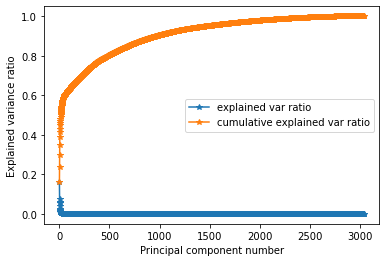

In [144]:
num_pcas = model_pca.components_
plt.figure()
plt.plot(range(1, len(num_pcas)+1), model_pca.explained_variance_ratio_, label="explained var ratio", marker="*")
plt.plot(range(1, len(num_pcas)+1), model_pca.explained_variance_ratio_.cumsum(), label="cumulative explained var ratio", marker="*")
plt.xlabel("Principal component number")
plt.ylabel("Explained variance ratio")
plt.legend()
plt.show()

Proceeding with ~80% of cumulative explained variance at 550 PCs

In [145]:
model_pca = PCA(n_components=550).fit(X_train_mm)
X_train_PCA = model_pca.transform(X_train_mm)
X_train_PCA

In [147]:
plt.figure(figsize=(12,10))
sns.heatmap(abs(X_train_PCA.corr()), cmap="Oranges", vmin=0, vmax=1, center=0.5, annot=True, linewidths=2)
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'corr'

<Figure size 864x720 with 0 Axes>

# K Means

- OHE only
- No Scalar - implement with pipeline and GridSearchCV for standard and minmax


In [155]:
k_range = [50, 100, 200, 300, 400, 500, 600, 700]
k_inertias = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=5, n_jobs=-2).fit(X_train_PCA)
    k_inertias.append(kmeans.inertia_)

C:\Users\ikhwan\.conda\envs\bigdata_ml\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\ikhwan\.conda\envs\bigdata_ml\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\ikhwan\.conda\envs\bigdata_ml\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\ikhwan\.conda\envs\bigdata_ml\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' 

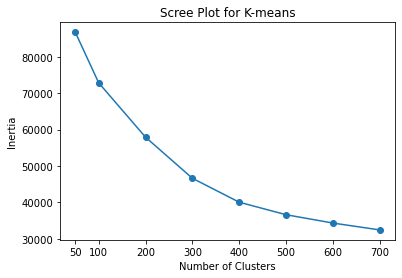

In [156]:
# Visualize
plt.figure()
plt.plot(k_range, k_inertias, marker="o")
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Scree Plot for K-means')
plt.xticks(k_range)
plt.show();

In [148]:
kmeans_100 = KMeans(n_clusters=400, random_state=5, n_jobs=-2).fit(X_train_PCA)

C:\Users\ikhwan\.conda\envs\bigdata_ml\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [1]:
kmeans_100.inertia_

NameError: name 'kmeans_100' is not defined

No need to continue with this.  This model is pretty terrible.

In [137]:
# # calculate silhouette and predict
# cluster_labels = kmeans_100.predict(X_train)


In [138]:
# cluster_labels

array([65, 65, 65, ..., 79, 79, 79])

In [ ]:
# from sklearn.metrics import silhouette_score

# DBSCAN

# GMM


In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

### pipeline and gscv
recursively optimized loop above using following gridsearch <br>
no PCA since 
MinMax should be good enough for the price ranges.  standard may skew price differences too much.

In [121]:
kmeans_estimators = [('scaler', MinMaxScaler()),
                    ('KMeans', KMeans())]

km_pipe = Pipeline(kmeans_estimators)

In [122]:
km_params = {'scaler': [MinMaxScaler()],
             'KMeans':[ KMeans()],
             'KMeans__n_clusters': [50, 150, 300]    
             }

In [123]:
km_grid = GridSearchCV(estimator=km_pipe, param_grid=km_params, cv=2, verbose=10, n_jobs=-2)

In [124]:
km_fitted = km_grid.fit(X_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


In [128]:
km_fitted.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()), ('KMeans', KMeans(n_clusters=80))])

In [129]:
km_fitted.cv_results_

{'mean_fit_time': array([125.70725989, 174.46700156, 297.34174979, 437.85900033]),
 'std_fit_time': array([ 5.90875077, 10.89699948,  4.03224957,  2.75999868]),
 'mean_score_time': array([4.58124197, 3.44924986, 2.36624992, 2.0777483 ]),
 'std_score_time': array([0.4027518 , 0.02975237, 0.01674902, 0.11674857]),
 'param_KMeans': masked_array(data=[KMeans(n_clusters=80), KMeans(n_clusters=80),
                    KMeans(n_clusters=80), KMeans(n_clusters=80)],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_KMeans__n_clusters': masked_array(data=[10, 20, 40, 80],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_scaler': masked_array(data=[MinMaxScaler(), MinMaxScaler(), MinMaxScaler(),
                    MinMaxScaler()],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'KMeans': KMeans(n_clusters=80),
  

In [ ]:
km_df = pd.DataFrame(km_grid.cv_results_)